[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dlssb/pytorch-exercise/blob/main/autoencoder.ipynb)

# Autoencoder

## 1. Settings

### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib as mpl

### 2) Set hyperparameters

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epochs = 20

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)  # The input image is scaled to [0.0, 1.0] if transforms.ToTensor() is applied.
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [50000, 10000])

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
dir(mnist_train)  # internal methods & variables

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'dataset',
 'indices']

In [5]:
len(mnist_train[0])  # tuple

2

In [6]:
mnist_train[0][0]  # data

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [7]:
mnist_train[0][1]  # label

8

In [8]:
mnist_train[0][0].size()    # (1, 28, 28)

torch.Size([1, 28, 28])

In [9]:
mnist_train[0][1]           # label

8

### 2) Set DataLoader

In [10]:
dataloaders = {}
dataloaders['train'] = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
dataloaders['val'] = DataLoader(mnist_val, batch_size=batch_size, shuffle=False)
dataloaders['test'] = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)

In [11]:
dataloaders.keys()

dict_keys(['train', 'val', 'test'])

In [12]:
len(dataloaders['train'])  # 196 * 256 = 50176

196

## 3. Model & Optimizer

### 1) Model

In [13]:
# build your own autoencoder
# in my case: 784(28*28) -> 100 -> 30 -> 100 -> 784(28*28)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),    
            nn.ReLU(),                          # activation function
            nn.Linear(100, 30),
            nn.ReLU()                           # activation function
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(30, 100),
            nn.ReLU(),                          # activation function
            nn.Linear(100, 28*28),
            nn.Sigmoid()                        # activation function
        )

                
    def forward(self, x):                # x: (batch_size, 1, 28, 28)
        batch_size = x.size(0)
        x = x.view(-1, 28*28)                          # reshape to 784(28*28)-dimensional vector
        encoded = self.encoder(x)                      # hidden vector
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)                 # final output. resize to input's size
        return out, encoded


### 2) Loss func & Optimizer

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## 4. Train 

In [16]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)                                       # transfer inputs to GPU 

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [17]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.1184
val Loss: 0.0703

Epoch 1/19
----------
train Loss: 0.0657
val Loss: 0.0603

Epoch 2/19
----------
train Loss: 0.0549
val Loss: 0.0502

Epoch 3/19
----------
train Loss: 0.0461
val Loss: 0.0432

Epoch 4/19
----------
train Loss: 0.0404
val Loss: 0.0385

Epoch 5/19
----------
train Loss: 0.0369
val Loss: 0.0358

Epoch 6/19
----------
train Loss: 0.0344
val Loss: 0.0334

Epoch 7/19
----------
train Loss: 0.0319
val Loss: 0.0308

Epoch 8/19
----------
train Loss: 0.0295
val Loss: 0.0286

Epoch 9/19
----------
train Loss: 0.0275
val Loss: 0.0269

Epoch 10/19
----------
train Loss: 0.0260
val Loss: 0.0254

Epoch 11/19
----------
train Loss: 0.0246
val Loss: 0.0241

Epoch 12/19
----------
train Loss: 0.0234
val Loss: 0.0230

Epoch 13/19
----------
train Loss: 0.0225
val Loss: 0.0222

Epoch 14/19
----------
train Loss: 0.0217
val Loss: 0.0215

Epoch 15/19
----------
train Loss: 0.0210
val Loss: 0.0209

Epoch 16/19
----------
train Loss: 0.0205
val Loss

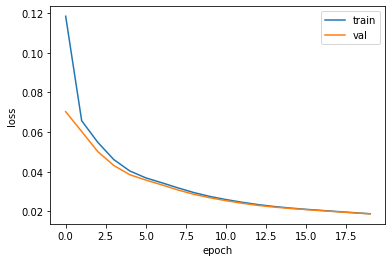

In [18]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## 5. Check with Test Image

In [19]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to(device)

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.018194282481074332


torch.Size([16, 28, 28])


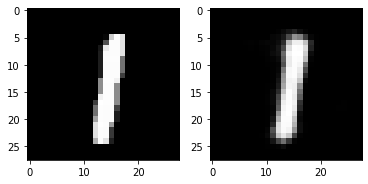

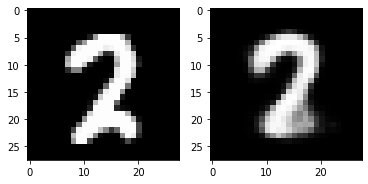

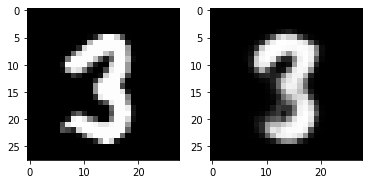

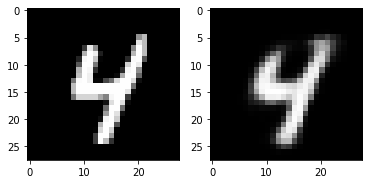

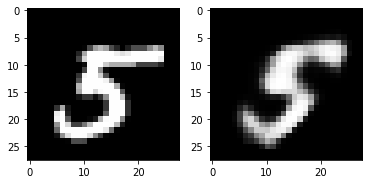

In [20]:
out_img = torch.squeeze(outputs.cpu())
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

## 6. Visualizing MNIST (TODO)

In [21]:
np.random.seed(42)

from sklearn.manifold import TSNE

In [22]:
test_dataset_array = mnist_test.data.numpy() / 255
test_dataset_array = np.float32(test_dataset_array)
labels = mnist_test.targets.numpy()

In [23]:
test_dataset_array = torch.tensor(test_dataset_array)
inputs = test_dataset_array.to(device)
outputs, encoded = best_model(inputs)

In [24]:
encoded = encoded.cpu().detach().numpy()
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


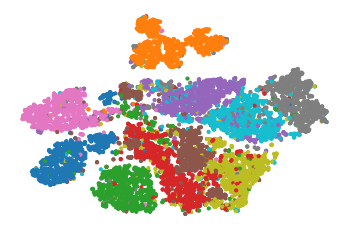

In [25]:
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

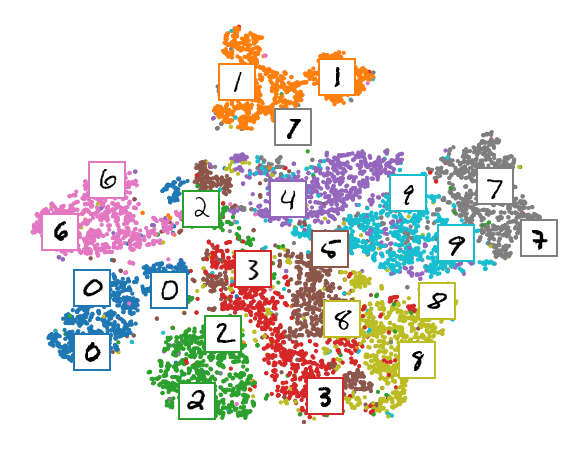

In [26]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_test_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(torch.squeeze(inputs).cpu().numpy()[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(labels[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

# Denoising Autoencoder

In [27]:
model_D = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model_D.parameters(), lr=learning_rate)

In [28]:
# It's all the same except for one: adding noise to inputs
# copy train_model() code and just add 'noise part'
# Hint: You can make noise like this.
# noise = torch.zeros(inputs.size(0), 1, 28, 28)
# nn.init.normal_(noise, 0, 0.1)

def train_model_D(model, dataloaders, criterion, optimizer, num_epochs=10):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                noise = torch.zeros(inputs.size(0), 1, 28, 28)
                nn.init.normal_(noise, 0, 0.1)
                noise = noise.to(device)
                inputs = inputs.to(device)
                noise_inputs = inputs + noise

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(noise_inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss


                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer

                # statistics
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)

            if phase == 'val':
                val_loss_history.append(epoch_loss)

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [29]:
best_model_D, train_loss_history_D, val_loss_history_D = train_model_D(model_D, dataloaders, loss_func, optimizer, num_epochs=num_epochs)

Epoch 0/19
----------
train Loss: 0.1151
val Loss: 0.0702

Epoch 1/19
----------
train Loss: 0.0647
val Loss: 0.0583

Epoch 2/19
----------
train Loss: 0.0529
val Loss: 0.0476

Epoch 3/19
----------
train Loss: 0.0449
val Loss: 0.0429

Epoch 4/19
----------
train Loss: 0.0402
val Loss: 0.0381

Epoch 5/19
----------
train Loss: 0.0359
val Loss: 0.0341

Epoch 6/19
----------
train Loss: 0.0325
val Loss: 0.0312

Epoch 7/19
----------
train Loss: 0.0299
val Loss: 0.0289

Epoch 8/19
----------
train Loss: 0.0279
val Loss: 0.0271

Epoch 9/19
----------
train Loss: 0.0262
val Loss: 0.0255

Epoch 10/19
----------
train Loss: 0.0248
val Loss: 0.0243

Epoch 11/19
----------
train Loss: 0.0236
val Loss: 0.0232

Epoch 12/19
----------
train Loss: 0.0227
val Loss: 0.0224

Epoch 13/19
----------
train Loss: 0.0218
val Loss: 0.0215

Epoch 14/19
----------
train Loss: 0.0210
val Loss: 0.0207

Epoch 15/19
----------
train Loss: 0.0203
val Loss: 0.0201

Epoch 16/19
----------
train Loss: 0.0196
val Loss

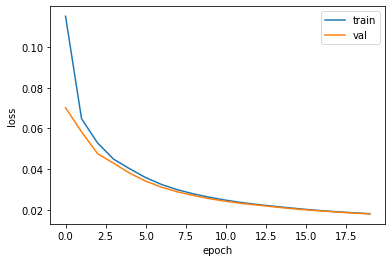

In [30]:
plt.plot(train_loss_history_D, label='train')
plt.plot(val_loss_history_D, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [31]:
with torch.no_grad():
  running_loss = 0.0
  for inputs, labels in dataloaders['test']:
      noise = nn.init.normal_(torch.FloatTensor(inputs.size(0), 1, 28, 28), 0, 0.1)
      noise = noise.to(device)
      inputs = inputs.to(device)
      noise_inputs = inputs + noise

      outputs, encoded = best_model_D(noise_inputs)
      test_loss = loss_func(outputs, inputs)
      
      running_loss += test_loss.item()* inputs.size(0)

  test_loss = running_loss / len(dataloaders['test'].dataset)
  print(test_loss) 

0.01747801296263933


torch.Size([16, 28, 28])


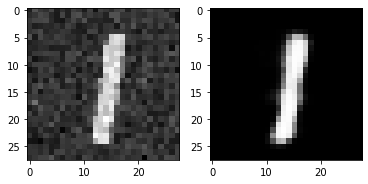

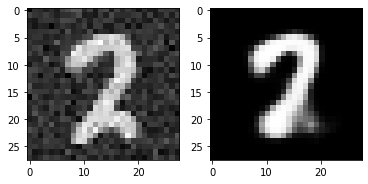

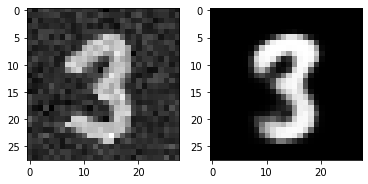

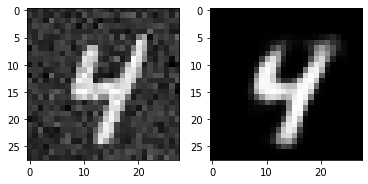

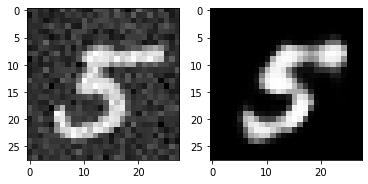

In [32]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(noise_inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()